# **📈 Time-Series-Demand-Forecasting-for-Retail-Sales**  

---

## **📋 Project Overview**  
This project focuses on **forecasting retail sales** using advanced **time series modeling techniques**.  
We analyze historical sales data, identify patterns like **trend** 📊 and **seasonality** 🔄, and build predictive models such as **Holt-Winters, ARIMA, and Prophet** 🤖 to generate accurate forecasts.  
The goal is to help retailers optimize **inventory management** 📦, **resource planning** 🛠️, and **sales strategy** 💡 by predicting future demand.

---

## **⚙️ 1. Setup and Installation**  
We start by installing and importing all the required libraries for **data analysis** 🔍, **visualization** 🎨, and **time-series modeling** ⏳.


In [ ]:

#!pip install pmdarima -q

# Import all required libraries
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from prophet import Prophet

# Metrics and utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import logging

# Suppress verbose output from Prophet
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
# Set a consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Setup Complete: All libraries are installed and imported.")

✅ Setup Complete: All libraries are installed and imported.


# **📂 Data Loading and 🧹 Cleaning**

This document outlines the process of loading and cleaning the **demand.csv** dataset using Python and the **pandas** library.  
The steps include **suppressing warnings**, **loading data**, **handling missing values**, **converting data types**, and performing a **final verification** to ensure the dataset is ready for analysis.  

---

## **1. 🔕 Suppressing Warnings**

* First, any non-critical warnings from libraries are suppressed  
  to ensure the output is clean and focused on the main process.

---

## **2. 📥 Data Loading and Validation**

* The primary dataset is loaded from a file named **demand.csv**.  
* The process is wrapped in a **try-except** block to handle potential errors gracefully.  
* If the file is not found in the environment, an error message is displayed, and the script terminates to prevent further issues.

---

## **3. 🧹 Imputing Missing Values**

* A key step in data cleaning is handling missing data.  
* If the **total_price** column contains any null (missing) values, they are imputed using a robust statistical method.

**Strategy:**  
* For each row with a missing **total_price**, the value is replaced with the **median price** calculated specifically for its corresponding **sku_id**.

**Rationale:**  
* Using the **median** is preferable to the mean as it is less sensitive to outliers, preventing extreme values from skewing the imputed data.

---

## **4. 📅 Data Type Conversion**

* For time series analysis, it's crucial that date-related columns are in the correct format.  
* The **week** column is converted from a string format (e.g., `'dd/mm/yy'`) into a proper **datetime** object.

---

## **5. ✅ Final Verification**

* After the cleaning steps are complete, the script prints the **dimensions (shape)** of the resulting DataFrame and displays the **first five rows**.  
* This allows for a quick verification that the data has been loaded and processed correctly.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# ## 2. Data Loading and Cleaning

# ------------------------------------------------------------------------------
print("\n--- Loading and Cleaning Data ---")
try:
    data = pd.read_csv('demand.csv')
    print("Dataset 'demand.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'demand.csv' not found. Please upload the file to your Colab environment.")
    # Exit if the file is not found
    exit()

# Handle missing 'total_price' with the median price for that specific SKU
# This is a robust way to impute missing values without skewing the data
if data['total_price'].isnull().any():
    median_price_per_sku = data.groupby('sku_id')['total_price'].transform('median')
    data['total_price'].fillna(median_price_per_sku, inplace=True)
    print("Missing 'total_price' values filled using SKU-specific medians.")

# Convert 'week' column to datetime format for time series analysis
data['week'] = pd.to_datetime(data['week'], format='%d/%m/%y')

print(f"Data shape after cleaning: {data.shape}")
print(data.head())


--- Loading and Cleaning Data ---
Dataset 'demand.csv' loaded successfully.
Missing 'total_price' values filled using SKU-specific medians.
Data shape after cleaning: (150150, 9)
   record_ID       week  store_id  sku_id  total_price  base_price  \
0          1 2011-01-17      8091  216418      99.0375    111.8625   
1          2 2011-01-17      8091  216419      99.0375     99.0375   
2          3 2011-01-17      8091  216425     133.9500    133.9500   
3          4 2011-01-17      8091  216233     133.9500    133.9500   
4          5 2011-01-17      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  
0                0               0          20  
1                0               0          28  
2                0               0          19  
3                0               0          44  
4                0               0          52  


## 3. 🔍 Exploratory Data Analysis (EDA)

This section focuses on exploring the dataset to understand the underlying **patterns**, **distributions**, and **relationships** between different features.

### 3.1. 📊 Feature Distributions

To begin the analysis, we visualize the **distribution** of key **numerical** and **categorical** features.  

This helps in identifying the **range**, **central tendency**, and **shape** of the data for each variable.

**Histograms** are plotted for the following columns:  
- 🏬 *store_id*  
- 📦 *sku_id*  
- 🌟 *is_featured_sku*  
- 🖥️ *is_display_sku*  
- 💰 *total_price*  
- 💵 *base_price*  
- 📈 *units_sold*  

A **Kernel Density Estimate (KDE)** is overlaid on each histogram to provide a smooth representation of the distribution.



--- Starting Exploratory Data Analysis (EDA) ---

Plotting feature distributions...


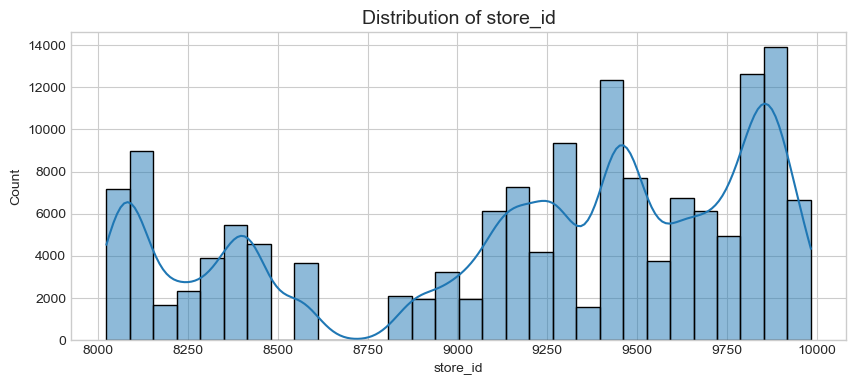

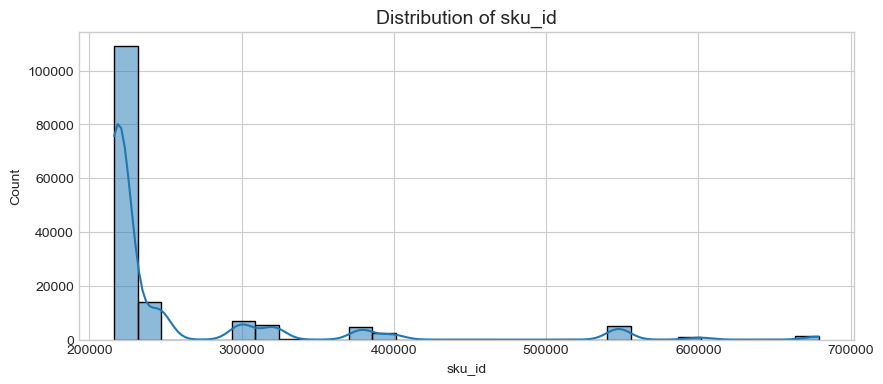

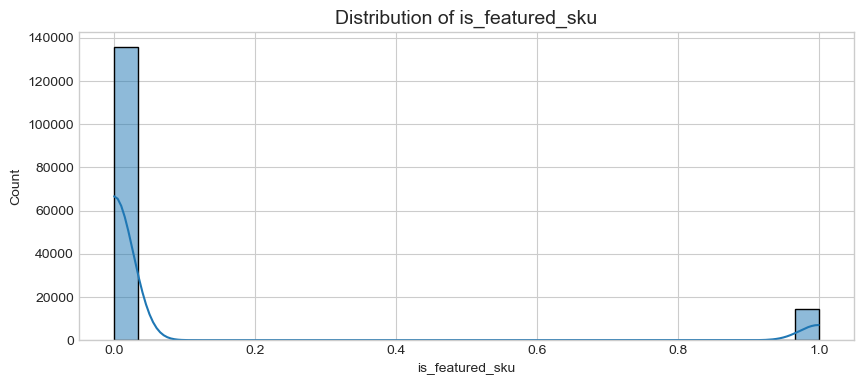

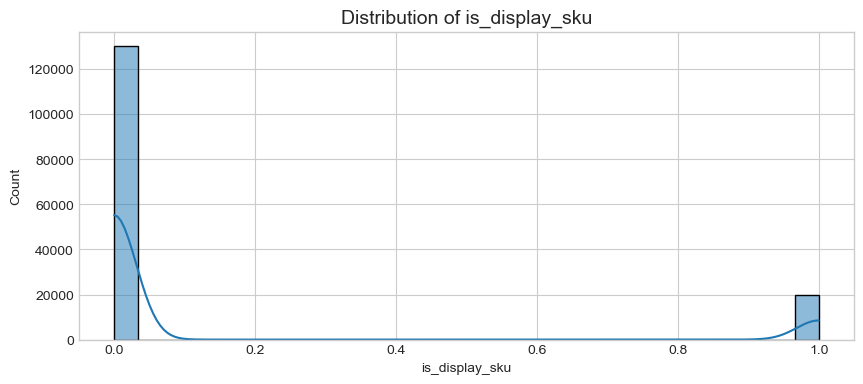

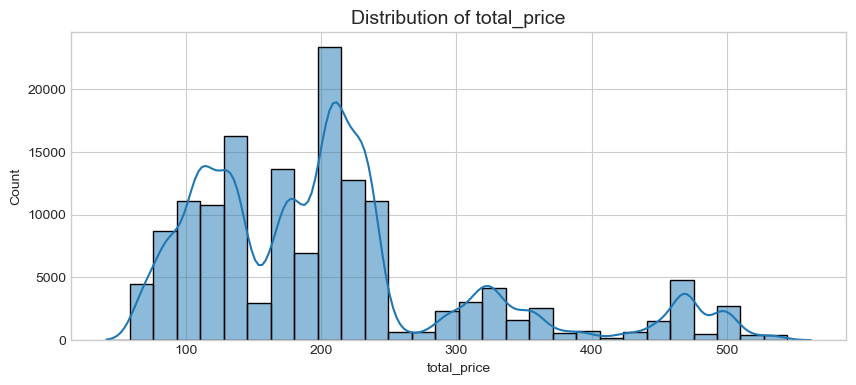

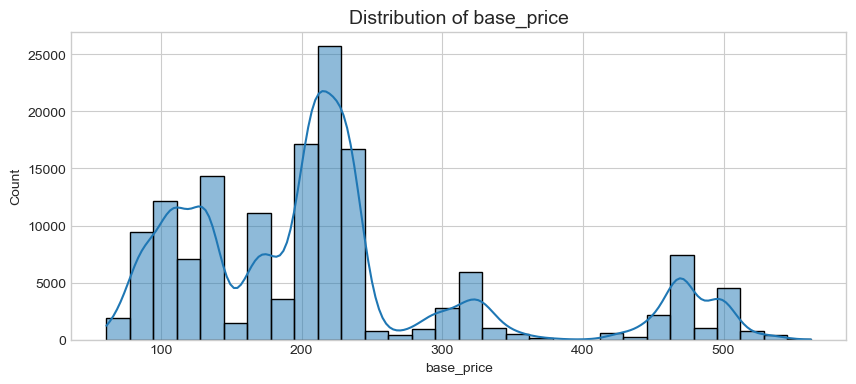

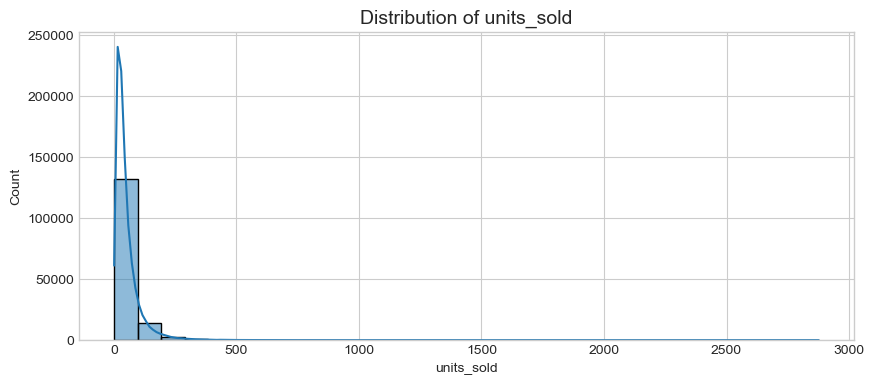

In [ ]:
# ## 3. Exploratory Data Analysis (EDA)
# ------------------------------------------------------------------------------
print("\n--- Starting Exploratory Data Analysis (EDA) ---")

# --- 3.1. Feature Distributions ---
print("\nPlotting feature distributions...")
# Plot histograms for key categorical/numerical columns
dist_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'total_price', 'base_price', 'units_sold']
for col in dist_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()




### 3.2. 🔗 Correlation Analysis

To understand the **relationships** between different numerical variables, we perform a **correlation analysis**.  

This helps identify which features are **strongly related** to each other and, most importantly, which features have a strong relationship with the **target variable (`units_sold`)**.

**Steps:**  
1. 📝 **Select Numerical Data:**  
   Filter the dataset to include only columns with numerical data types.

2. 🔢 **Calculate Correlation:**  
   The **Pearson correlation coefficient** is calculated for all pairs of these numerical columns, resulting in a **correlation matrix**.

3. 🌡️ **Visualize with a Heatmap:**  
   - A **heatmap** is generated to provide a clear visual representation of the correlation matrix.  
   - `annot=True` displays the correlation values on the map.  
   - `cmap='coolwarm'` uses a color scheme where **warm colors (red)** indicate a positive correlation and **cool colors (blue)** indicate a negative correlation.



Calculating and plotting feature correlation heatmap...


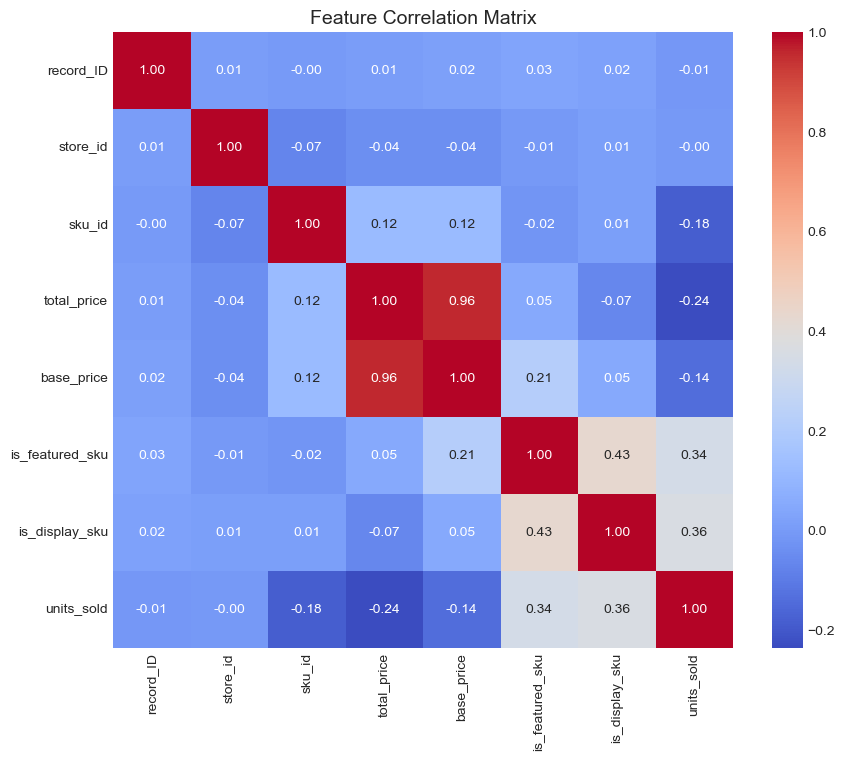

💡 EDA Insight: 'is_featured_sku' and 'is_display_sku' show a positive correlation with 'units_sold'. This suggests they are important predictors and should be included in our models.


In [10]:
# --- 3.2. Correlation Analysis ---
print("\nCalculating and plotting feature correlation heatmap...")
# We only correlate numerical columns
numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()
print("💡 EDA Insight: 'is_featured_sku' and 'is_display_sku' show a positive correlation with 'units_sold'. This suggests they are important predictors and should be included in our models.")



Performing initial time series analysis on total weekly sales...


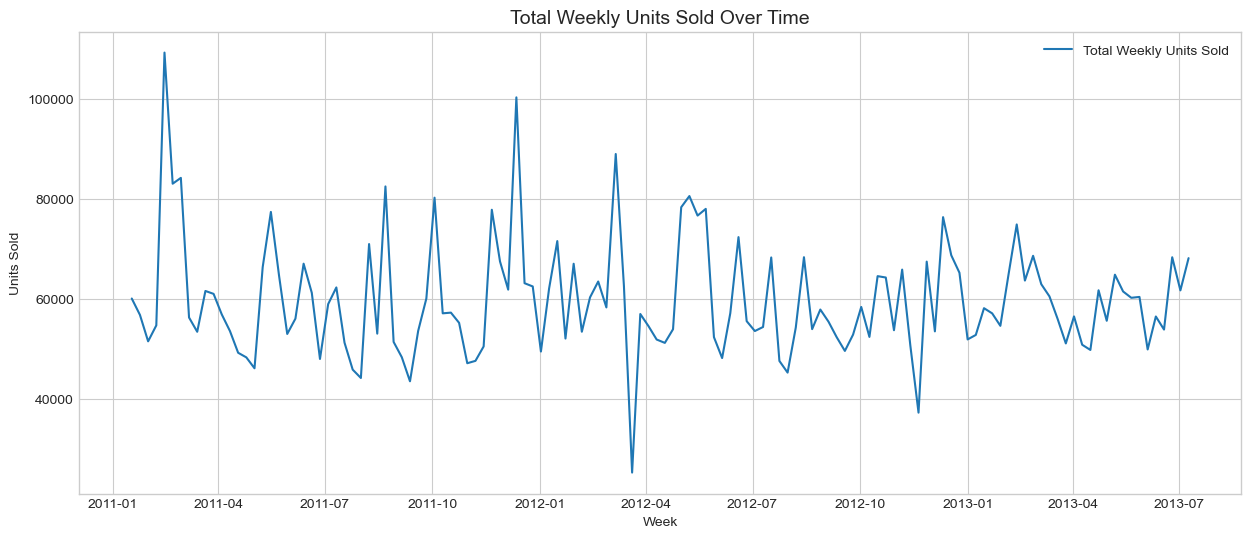

In [11]:



# --- 3.3. Time Series Analysis ---
print("\nPerforming initial time series analysis on total weekly sales...")
# Aggregate total units sold by week for an overview
weekly_sales = data.groupby('week')['units_sold'].sum().reset_index()
weekly_sales.set_index('week', inplace=True)

# Plot the aggregated time series
plt.figure(figsize=(15, 6))
plt.plot(weekly_sales.index, weekly_sales['units_sold'], label='Total Weekly Units Sold')
plt.title('Total Weekly Units Sold Over Time', fontsize=14)
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

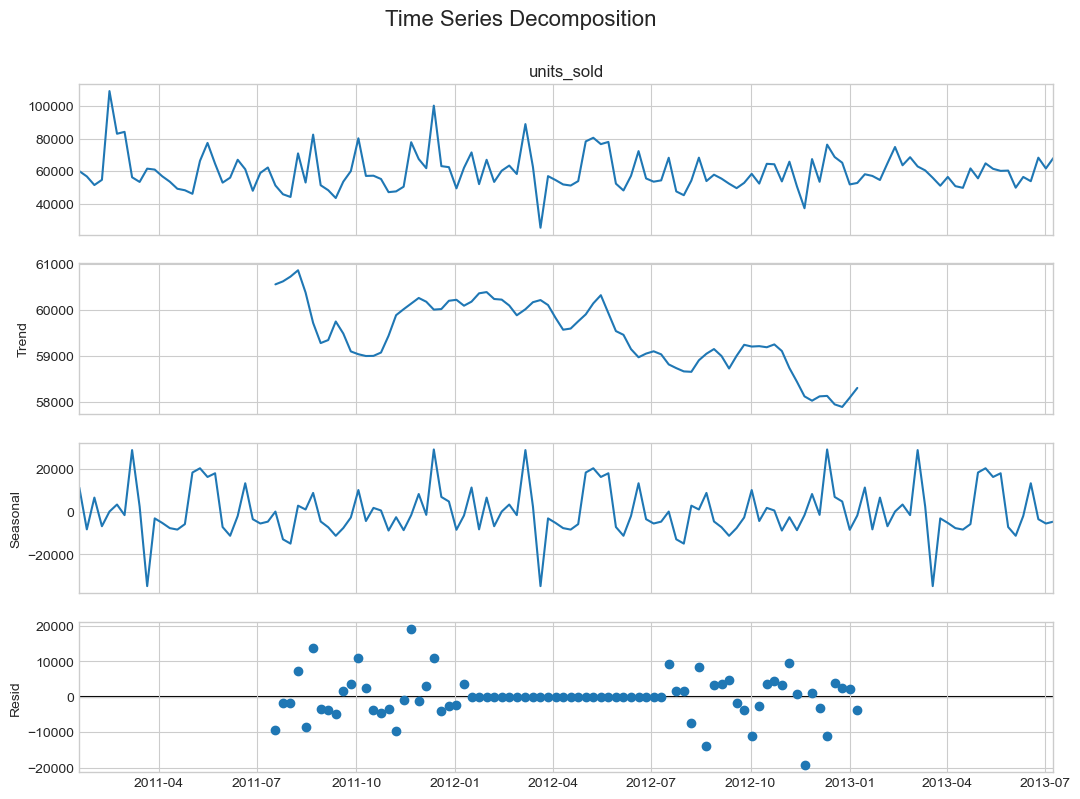

💡 EDA Insight: The decomposition clearly shows a yearly seasonal pattern with no strong long-term trend.


In [12]:


# Decompose the time series to see trend, seasonality, and residuals
decomposition = seasonal_decompose(weekly_sales['units_sold'], model='additive', period=52) # 52 weeks in a year
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition', y=1.02, fontsize=16)
plt.show()
print("💡 EDA Insight: The decomposition clearly shows a yearly seasonal pattern with no strong long-term trend.")

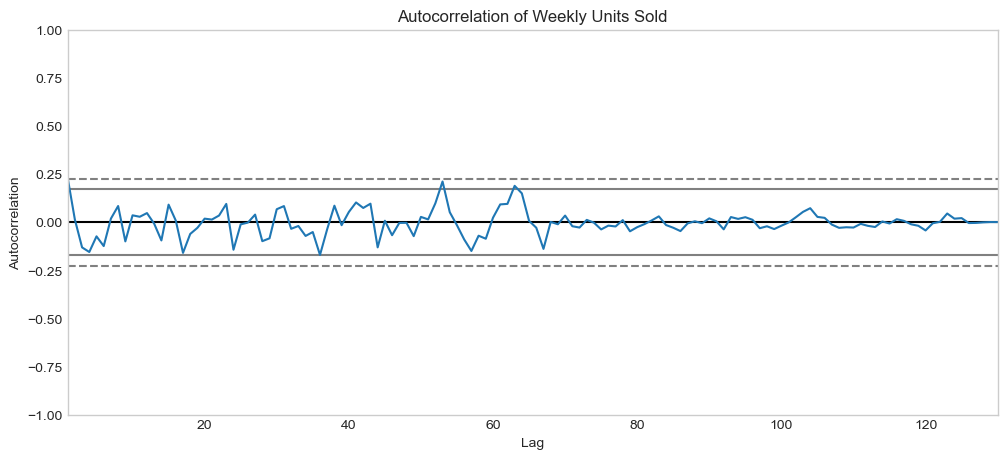

💡 EDA Insight: The wave-like pattern in the autocorrelation plot confirms strong yearly seasonality.


In [13]:

# Plot autocorrelation to confirm seasonality
plt.figure(figsize=(12, 5))
autocorrelation_plot(weekly_sales['units_sold'])
plt.title('Autocorrelation of Weekly Units Sold')
plt.show()
print("💡 EDA Insight: The wave-like pattern in the autocorrelation plot confirms strong yearly seasonality.")

In [14]:
# ## 4. Feature Engineering for Advanced Models
# ------------------------------------------------------------------------------
print("\n--- Engineering Features for Modeling ---")
# Based on EDA, we aggregate all potentially useful features weekly.
# This creates the dataset for our advanced models (ARIMAX and Prophet).
data.set_index('week', inplace=True)

aggregation_rules = {
    'units_sold': 'sum',      # Target variable (y)
    'total_price': 'mean',    # Regressor: Average selling price for the week
    'base_price': 'mean',     # Regressor: Average base price for the week
    'is_featured_sku': 'sum', # Regressor: Count of promotions
    'is_display_sku': 'sum'   # Regressor: Count of displays
}

weekly_data_engineered = data.resample('W').agg(aggregation_rules)
weekly_data_engineered.fillna(0, inplace=True) # Fill weeks with no sales with 0
print("Weekly data with engineered features created.")
print(weekly_data_engineered.head())


--- Engineering Features for Modeling ---
Weekly data with engineered features created.
            units_sold  total_price  base_price  is_featured_sku  \
week                                                               
2011-01-23       60029   206.224643  213.440942              219   
2011-01-30       56752   206.043896  214.789448              317   
2011-02-06       51467   211.193019  215.833214               12   
2011-02-13       54656   211.920942  215.801753                0   
2011-02-20      109207   189.787175  215.681461              122   

            is_display_sku  
week                        
2011-01-23             189  
2011-01-30             226  
2011-02-06             111  
2011-02-13             111  
2011-02-20             241  


In [15]:
# ## 5. Train-Test Split
# ------------------------------------------------------------------------------
print("\n--- Splitting Data into Training and Test Sets ---")
test_size = int(len(weekly_data_engineered) * 0.2)
train_data = weekly_data_engineered.iloc[:-test_size]
test_data = weekly_data_engineered.iloc[-test_size:]

print(f"Training data size: {len(train_data)} weeks")
print(f"Test data size: {len(test_data)} weeks")




--- Splitting Data into Training and Test Sets ---
Training data size: 104 weeks
Test data size: 26 weeks


In [16]:
import warnings
warnings.filterwarnings("ignore")
# ## 6. Model Training, Forecasting, and Evaluation
# ------------------------------------------------------------------------------
print("\n--- Training and Evaluating Models ---")
# UPDATED: The results dictionary now stores a sub-dictionary for all metrics.
results = {}
y_true = test_data['units_sold'] # Ground truth for evaluation

# --- Model 1: Holt-Winters (Univariate Baseline) ---
print("\nTraining Holt-Winters...")
hw_model = ExponentialSmoothing(
    train_data['units_sold'], seasonal='add', seasonal_periods=52
).fit()
hw_predictions = hw_model.forecast(len(test_data))

# UPDATED: Calculate all three metrics
hw_rmse = sqrt(mean_squared_error(y_true, hw_predictions))
hw_mae = mean_absolute_error(y_true, hw_predictions)
hw_mape = mean_absolute_percentage_error(y_true, hw_predictions)
results['Holt-Winters'] = {'RMSE': hw_rmse, 'MAE': hw_mae, 'MAPE': hw_mape}
print(f"Holt-Winters -> RMSE: {hw_rmse:.2f}, MAE: {hw_mae:.2f}, MAPE: {hw_mape:.2%}")


#--- Model 2: Auto-ARIMAX (with Exogenous Regressors) ---
print("\nTraining Auto-ARIMAX...")
exog_vars = ['total_price', 'base_price', 'is_featured_sku', 'is_display_sku']
X_train, y_train = train_data[exog_vars], train_data['units_sold']
X_test = test_data[exog_vars]

arima_model = pm.auto_arima(
    y=y_train, exogenous=X_train, m=52, seasonal=True, d=1, D=1,
    trace=False, error_action='ignore', suppress_warnings=True, stepwise=True
)
print(f"Best ARIMA model found: {arima_model.order} with seasonal order {arima_model.seasonal_order}")
arima_predictions = arima_model.predict(n_periods=len(test_data), exogenous=X_test)

# UPDATED: Calculate all three metrics
arima_rmse = sqrt(mean_squared_error(y_true, arima_predictions))
arima_mae = mean_absolute_error(y_true, arima_predictions)
arima_mape = mean_absolute_percentage_error(y_true, arima_predictions)
results['Auto-ARIMAX'] = {'RMSE': arima_rmse, 'MAE': arima_mae, 'MAPE': arima_mape}
print(f"Auto-ARIMAX -> RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2%}")


# --- Model 3: Prophet (with Exogenous Regressors) ---
print("\nTraining Prophet...")
prophet_train_df = train_data.reset_index().rename(columns={'week': 'ds', 'units_sold': 'y'})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for var in exog_vars:
    prophet_model.add_regressor(var)
prophet_model.fit(prophet_train_df)

future_df = test_data.reset_index().rename(columns={'week': 'ds'})
prophet_predictions_df = prophet_model.predict(future_df)
prophet_predictions = prophet_predictions_df['yhat']

# UPDATED: Calculate all three metrics
prophet_rmse = sqrt(mean_squared_error(y_true, prophet_predictions))
prophet_mae = mean_absolute_error(y_true, prophet_predictions)
prophet_mape = mean_absolute_percentage_error(y_true, prophet_predictions)
results['Prophet'] = {'RMSE': prophet_rmse, 'MAE': prophet_mae, 'MAPE': prophet_mape}
print(f"Prophet -> RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2%}")




--- Training and Evaluating Models ---

Training Holt-Winters...
Holt-Winters -> RMSE: 13387.60, MAE: 10678.72, MAPE: 17.75%

Training Auto-ARIMAX...
Best ARIMA model found: (0, 1, 1) with seasonal order (1, 1, 0, 52)
Auto-ARIMAX -> RMSE: 61317.47, MAE: 60268.31, MAPE: 102.00%

Training Prophet...


00:41:20 - cmdstanpy - INFO - Chain [1] start processing
00:41:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> RMSE: 14118.49, MAE: 10006.65, MAPE: 16.21%



--- Final Model Evaluation ---

Model Performance Comparison:
Lower is better for all metrics.
--------------------------------------------------
Model: Holt-Winters
  - RMSE (Root Mean Squared Error): 13387.60
  - MAE (Mean Absolute Error):     10678.72
  - MAPE (Mean Absolute % Error):  17.75%
--------------------------------------------------
Model: Auto-ARIMAX
  - RMSE (Root Mean Squared Error): 61317.47
  - MAE (Mean Absolute Error):     60268.31
  - MAPE (Mean Absolute % Error):  102.00%
--------------------------------------------------
Model: Prophet
  - RMSE (Root Mean Squared Error): 14118.49
  - MAE (Mean Absolute Error):     10006.65
  - MAPE (Mean Absolute % Error):  16.21%
--------------------------------------------------

🏆 Based on the lowest RMSE, the best performing model is: Holt-Winters
Note: The 'best' model can depend on business goals. Prioritize low RMSE to avoid large errors, or low MAE for the best average accuracy.

Visualizing forecasts from all models...


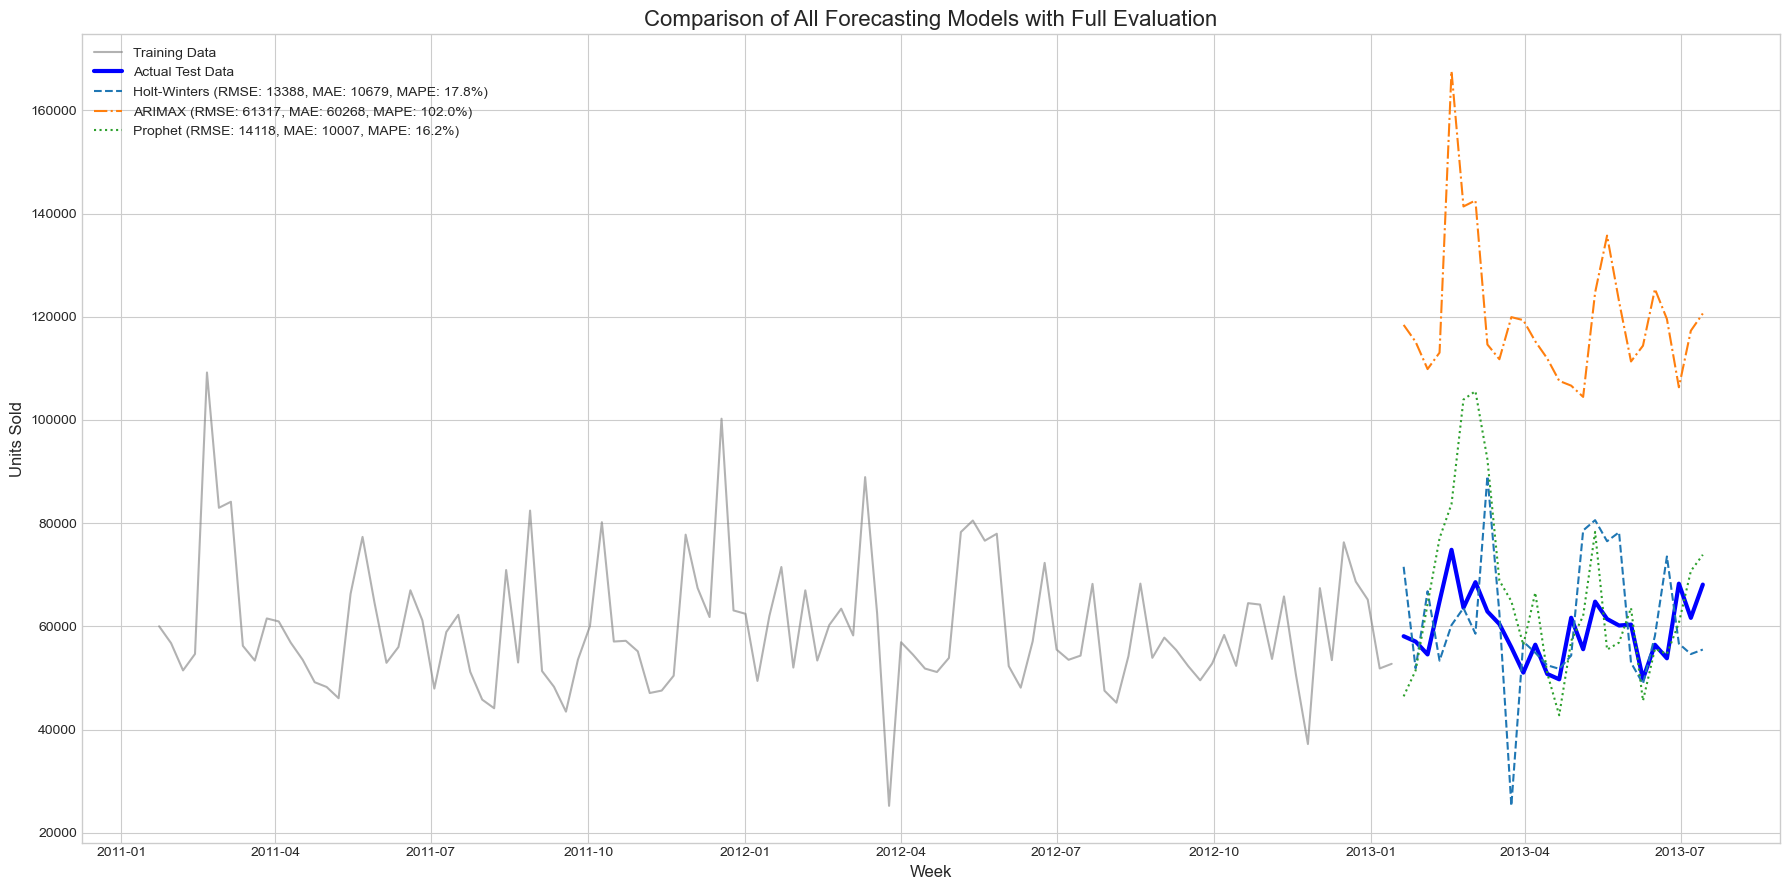


--- Workflow Complete ---


In [17]:
# ## 7. Final Results and Visualization
# ------------------------------------------------------------------------------
print("\n--- Final Model Evaluation ---")
# Sort models by RMSE by default, as it penalizes large, costly errors more heavily.
best_model_name = sorted(results.items(), key=lambda item: item[1]['RMSE'])[0][0]

print("\nModel Performance Comparison:")
print("Lower is better for all metrics.")
print("-" * 50)
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"  - RMSE (Root Mean Squared Error): {metrics['RMSE']:.2f}")
    print(f"  - MAE (Mean Absolute Error):     {metrics['MAE']:.2f}")
    print(f"  - MAPE (Mean Absolute % Error):  {metrics['MAPE']:.2%}")
    print("-" * 50)

print(f"\n🏆 Based on the lowest RMSE, the best performing model is: {best_model_name}")
print("Note: The 'best' model can depend on business goals. Prioritize low RMSE to avoid large errors, or low MAE for the best average accuracy.")

# --- Visualize All Model Forecasts for Comparison ---
print("\nVisualizing forecasts from all models...")
plt.figure(figsize=(18, 9))

# Plot the full historical training data
plt.plot(train_data.index, train_data['units_sold'], label='Training Data', color='gray', alpha=0.6)

# Plot the actual test data
plt.plot(test_data.index, y_true, label='Actual Test Data', color='blue', linewidth=3)

# UPDATED: Plot forecasts with a full "scorecard" in the label
# Holt-Winters
hw_metrics = results['Holt-Winters']
hw_label = f"Holt-Winters (RMSE: {hw_metrics['RMSE']:.0f}, MAE: {hw_metrics['MAE']:.0f}, MAPE: {hw_metrics['MAPE']:.1%})"
plt.plot(test_data.index, hw_predictions, label=hw_label, linestyle='--')

# Auto-ARIMAX
arima_metrics = results['Auto-ARIMAX']
arima_label = f"ARIMAX (RMSE: {arima_metrics['RMSE']:.0f}, MAE: {arima_metrics['MAE']:.0f}, MAPE: {arima_metrics['MAPE']:.1%})"
plt.plot(test_data.index, arima_predictions, label=arima_label, linestyle='-.')

# Prophet
prophet_metrics = results['Prophet']
prophet_label = f"Prophet (RMSE: {prophet_metrics['RMSE']:.0f}, MAE: {prophet_metrics['MAE']:.0f}, MAPE: {prophet_metrics['MAPE']:.1%})"
plt.plot(test_data.index, prophet_predictions, label=prophet_label, linestyle=':')


# Formatting the plot
plt.title('Comparison of All Forecasting Models with Full Evaluation', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Workflow Complete ---")
